In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from scipy.sparse import csr_matrix

# Load dataset
beauty_data = pd.read_csv('Beauty_Retail_Shop_Transactions_Dataset__2024_.csv')

# Data Analysis

In [2]:
print("Basic Dataset Information:")
print("-" * 30)  # Add a separator for better readability

print(f"Number of Rows: {beauty_data.shape[0]}")
print(f"Number of Columns: {beauty_data.shape[1]}")
print(f"Column Data Types:\n{beauty_data.dtypes}")
print(f"Memory Usage: {beauty_data.memory_usage().sum() / 1024**2:.2f} MB")  # Format memory usage

print("\nSummary Statistics:")
print("-" * 30)

print(beauty_data.describe())

Basic Dataset Information:
------------------------------
Number of Rows: 10000
Number of Columns: 6
Column Data Types:
cust_id           object
prod_id           object
product_name      object
category          object
purchase_amt     float64
purchase_date     object
dtype: object
Memory Usage: 0.46 MB

Summary Statistics:
------------------------------
       purchase_amt
count  10000.000000
mean      57.084050
std       25.125422
min        6.990000
25%       43.490000
50%       56.490000
75%       78.990000
max       98.490000


## Identify top-selling products and categories

In [3]:
top_products = beauty_data['product_name'].value_counts().head(10)
top_categories = beauty_data['category'].value_counts()
print("Top-Selling Products:")
print(top_products)
print("\nTop Categories:")
print(top_categories)

Top-Selling Products:
product_name
Face Scrub             276
Sunscreen              257
Toner                  255
Hair Dryer             254
Blush                  251
Foundation             249
Teeth Whitening Kit    249
Nail Strengthener      248
Feminine Wash          248
Conditioner            248
Name: count, dtype: int64

Top Categories:
category
Skin Care            1250
Makeup               1174
Hair Care            1168
Tools/Accessories     961
Nail Care             933
Body Care             917
Fragrance             885
Oral Care             698
Hygiene               682
Shaving               678
Aromatherapy          654
Name: count, dtype: int64


## Visualizing top categories

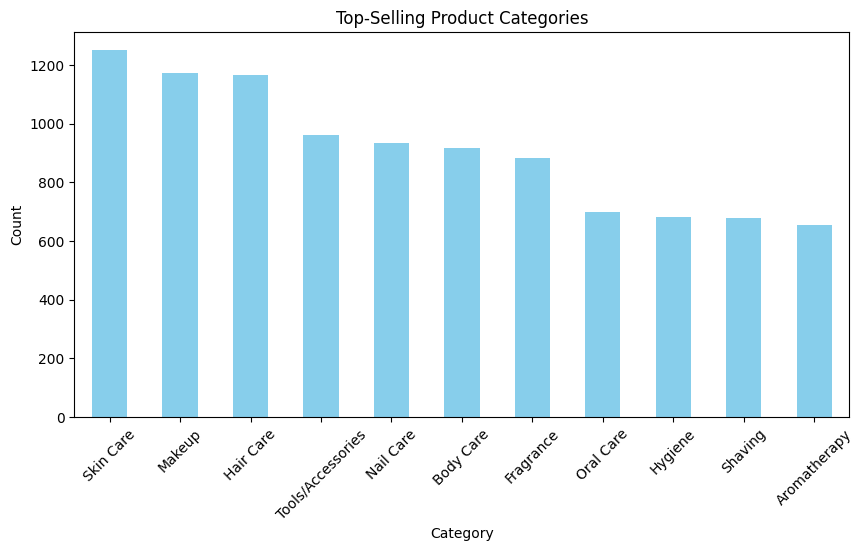

In [4]:
plt.figure(figsize=(10,5))
top_categories.plot(kind='bar', color='skyblue')
plt.title("Top-Selling Product Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Visualizing top Products

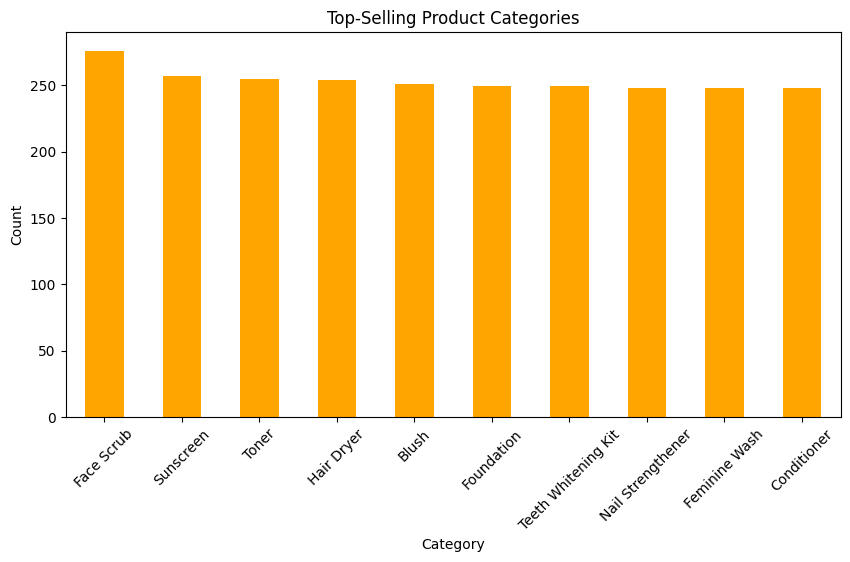

In [5]:
plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='orange')
plt.title("Top-Selling Product Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Visualizing Monthly Sales

<Figure size 1000x600 with 0 Axes>

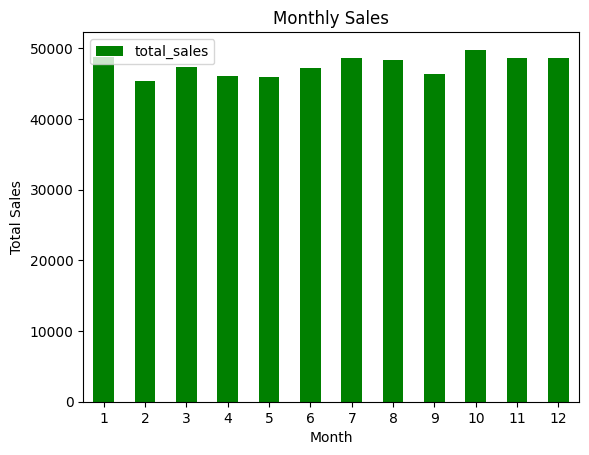

In [6]:
beauty_data['month'] = pd.to_datetime(beauty_data['purchase_date']).dt.month
monthly_sales = beauty_data.groupby('month').agg(total_sales=('purchase_amt', 'sum'))

# Plot monthly sales
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', color='green')
plt.title("Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.show()

## Clustering Customers Based on Spending and Frequency

In [7]:
customer_summary = beauty_data.groupby('cust_id').agg({
    'purchase_amt': 'sum',  # Total spending
    'product_name': 'count'  # Total purchases
}).rename(columns={'purchase_amt': 'total_spending', 'product_name': 'total_purchases'})

scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_summary)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_summary['cluster'] = kmeans.fit_predict(customer_features)
customer_summary['cluster_label'] = customer_summary['cluster'].map({
    0: 'High Spenders',
    1: 'Moderate Spenders',
    2: 'Occasional Buyers',
})
print("\nCustomer Segmentation:")
print(customer_summary.head())



Customer Segmentation:
         total_spending  total_purchases  cluster      cluster_label
cust_id                                                             
CUST001          931.32               18        2  Occasional Buyers
CUST002          819.82               18        2  Occasional Buyers
CUST003          744.87               13        0      High Spenders
CUST004          762.35               15        2  Occasional Buyers
CUST005          503.91                9        0      High Spenders


## Visualization of Cluster

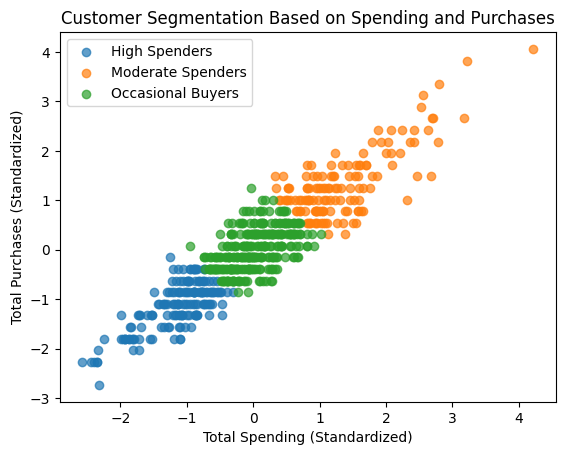

In [19]:
for cluster_num, label in {0: 'High Spenders', 1: 'Moderate Spenders', 2: 'Occasional Buyers'}.items():
    cluster_points = customer_features[customer_summary['cluster'] == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, alpha=0.7)  # Added alpha for visibility

plt.title("Customer Segmentation Based on Spending and Purchases")
plt.xlabel("Total Spending (Standardized)")
plt.ylabel("Total Purchases (Standardized)")
plt.legend()  # Add legend
plt.show()

## Seasonal trends in product purchases

In [9]:
season_mapping = {12: "Winter", 1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Autumn", 10: "Autumn", 11: "Autumn"}
beauty_data['season'] = beauty_data['month'].map(season_mapping)
seasonal_clusters = beauty_data.groupby("season").agg(total_sales=("purchase_amt", "sum"))


## Visualizing Seasonal Sales Trends

<Figure size 800x500 with 0 Axes>

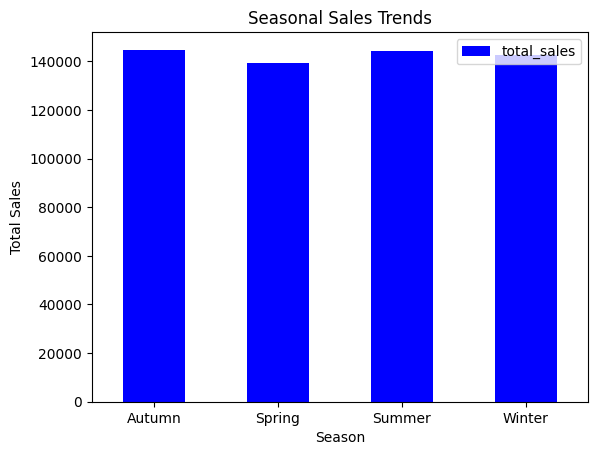

In [10]:
plt.figure(figsize=(8,5))
seasonal_clusters.plot(kind='bar', color='blue')
plt.title("Seasonal Sales Trends")
plt.xlabel("Season")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.show()

## Price sensitivity (sale vs. non-sale periods)

In [11]:
beauty_data['sale_period'] = beauty_data['month'].apply(lambda x: 'Sale' if x in [6, 12] else 'Non-Sale')
kmeans_price = KMeans(n_clusters=2, random_state=42, n_init=10)
beauty_data['price_cluster'] = kmeans_price.fit_predict(beauty_data[['purchase_amt']])


## Visualizing Sale vs Non-Sale Sales

<Figure size 600x400 with 0 Axes>

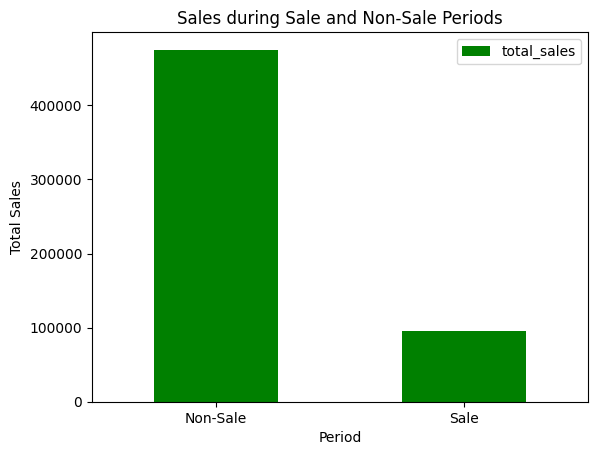

In [12]:
sale_sales = beauty_data.groupby("sale_period").agg(total_sales=("purchase_amt", "sum"))
plt.figure(figsize=(6,4))
sale_sales.plot(kind='bar', color=['green', 'red'])
plt.title("Sales during Sale and Non-Sale Periods")
plt.xlabel("Period")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.show()


# Recommendation Systems

## Customers Also Bought This (Collaborative Filtering)

In [13]:
customer_product_matrix = beauty_data.pivot_table(index='cust_id', columns='product_name', values='purchase_amt', aggfunc='sum', fill_value=0)
sparse_matrix = csr_matrix(customer_product_matrix)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(sparse_matrix)

def recommend_products_knn(customer_id, n_recommendations=3):
    if customer_id not in customer_product_matrix.index:
        return "Customer not found."
    customer_index = customer_product_matrix.index.get_loc(customer_id)
    distances, indices = model_knn.kneighbors(customer_product_matrix.iloc[customer_index, :].values.reshape(1, -1), n_neighbors=4)
    similar_customers = [customer_product_matrix.index[i] for i in indices.flatten()][1:]
    recommended_products = defaultdict(int)
    for sim_cust in similar_customers:
        top_products = beauty_data[beauty_data['cust_id'] == sim_cust]['product_name'].value_counts().head(n_recommendations)
        for product in top_products.index:
            recommended_products[product] += top_products[product]
    sorted_recommendations = sorted(recommended_products.items(), key=lambda x: x[1], reverse=True)
    return [product for product, count in sorted_recommendations[:n_recommendations]]

## Based on Past Purchases (Content-Based Filtering)

In [14]:
## "Based on Your Past Purchases" (Content-Based Filtering)
def recommend_products_content_based(customer_id, n_recommendations=3):
    if customer_id not in beauty_data['cust_id'].unique():
        return "Customer not found."
    purchased_products = beauty_data[beauty_data['cust_id'] == customer_id]['product_name'].unique()
    category = beauty_data[beauty_data['product_name'].isin(purchased_products)]['category'].mode()[0]
    similar_products = beauty_data[beauty_data['category'] == category]['product_name'].value_counts().index[:n_recommendations].tolist()
    return similar_products

## Based on the Weather (Context-Aware Recommendations)

In [15]:
def recommend_weather_based(season, n_recommendations=3):
    top_products = beauty_data[beauty_data['season'] == season]['product_name'].value_counts().head(n_recommendations).index.tolist()
    return top_products

## Steals for You (Sale-Based Recommendations)

In [16]:
def recommend_sale_products(n_recommendations=3):
    return beauty_data[beauty_data['sale_period'] == 'Sale']['product_name'].value_counts().index[:n_recommendations].tolist()

In [17]:
# Example usage
customer_id_example = 'CUST001'
season_example = "Winter"
print(f"Recommended items using KNN for {customer_id_example}: {recommend_products_knn(customer_id_example)}")
print(f"Recommended items using Content-Based Filtering for {customer_id_example}: {recommend_products_content_based(customer_id_example)}")
print(f"Most Popular Products during Sales: {recommend_sale_products()}")
print(f"Recommended items based on {season_example} weather: {recommend_weather_based(season_example)}")

Recommended items using KNN for CUST001: ['Face Scrub', 'Body Mist', 'Nail Strengthener']
Recommended items using Content-Based Filtering for CUST001: ['Conditioner', 'Hair Oil', 'Shampoo']
Most Popular Products during Sales: ['Eyelash Curler', 'Face Scrub', 'Body Scrub']
Recommended items based on Winter weather: ['Sunscreen', 'Lipstick', 'Teeth Whitening Kit']
